In [1]:
import numpy as np
import os
from pathlib import Path
import tarfile
import matplotlib.pyplot as plt

from nilearn import plotting, image, datasets
from nilearn.maskers import NiftiSpheresMasker
from nilearn.connectome import ConnectivityMeasure
import nibabel as nib

from sklearn.covariance import GraphicalLassoCV

## Loading the Dataset

In [2]:
folder = 'HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2'

# Get a list of fMRI data for all 1003 subjects
file_paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.txt')]

In [12]:
all_data = [np.loadtxt(path) for path in file_paths]

In [14]:
all_data = np.array(all_data)
all_data.shape

(1003, 4800, 100)

(4800,)


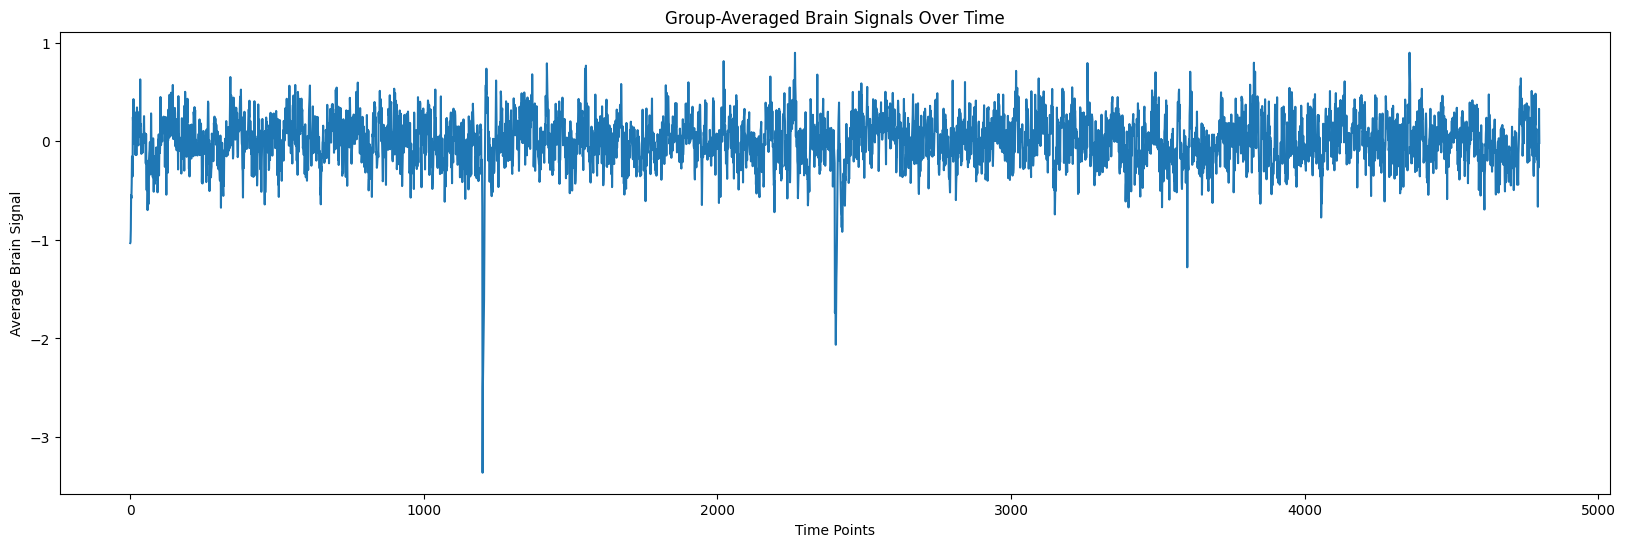

In [3]:
# Calculate the average brain signal for all 1003 subjects at each time point
all_subjects_data = []
for file_path in file_paths:
    data = np.loadtxt(file_path)  
    avg_across_regions = np.mean(data, axis=1)  # Average across 100 regions, shape == (4800,)
    all_subjects_data.append(avg_across_regions)

## print(len(all_subjects_data))

# Calculate average brain signal across individuals at each time point
group_avg_across_individuals = np.mean(np.vstack(all_subjects_data), axis=0)
print(group_avg_across_individuals.shape)

# Visualize the group-averaged brain activity over time
plt.figure(figsize=(20,6))
plt.plot(group_avg_across_individuals)
plt.xlabel('Time Points')
plt.ylabel('Average Brain Signal')
plt.title('Group-Averaged Brain Signals Over Time')
plt.show()

## Pair-wise correlation matrix

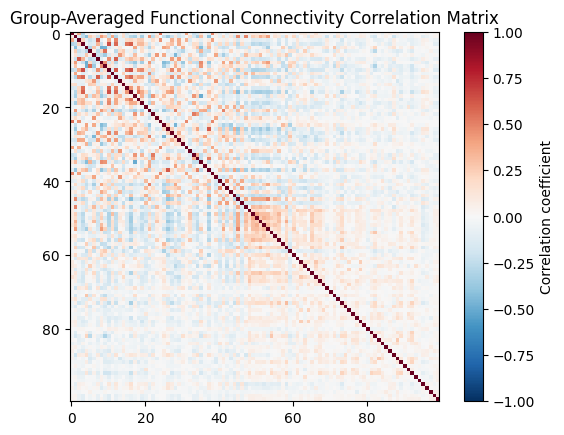

In [6]:
correlation_matrices = []
# get a pairwise correlation matrix for each individual's brain regions
for file_path in file_paths:
    data = np.loadtxt(file_path) 
    corr_matrix = np.corrcoef(data.T)  # correlation between each pair of brain regions
    correlation_matrices.append(corr_matrix)

# get the average across individuals to see average correlation
group_avg_correlation_matrix = np.mean(np.stack(correlation_matrices), axis=0)

# visualize the group-averaged correlation matrix
plt.imshow(group_avg_correlation_matrix,  cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation coefficient')
plt.title('Group-Averaged Functional Connectivity Correlation Matrix')
plt.show()

atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


Text(0.5, 1.0, 'Map of Brain Regions')

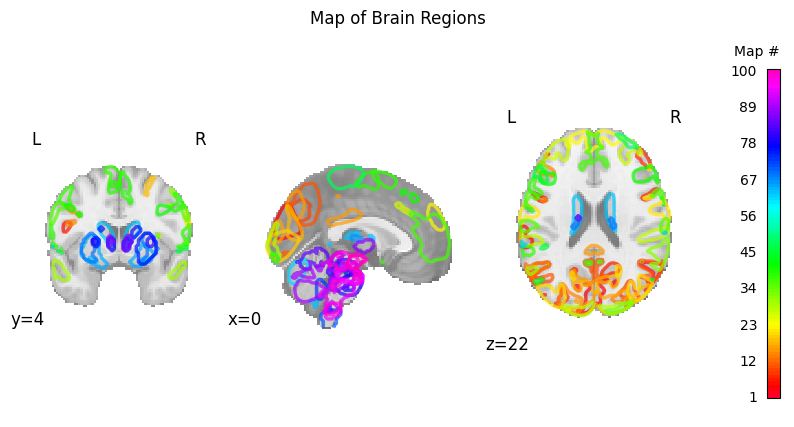

In [51]:
### Visualizing with the brain regions

atlas = image.load_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz")
atlas = image.threshold_img(atlas, "99.5%") 
print("atlas has shape", ["x", "y", "z", "region"], "=", atlas.shape)

fig, axs = plt.subplots(nrows=1, figsize=(10, 5))

# plot atlas, all regions
plotting.plot_prob_atlas(atlas, colorbar=True, draw_cross=False, axes=axs)
axs.set_title("Map of Brain Regions")

Text(0.5, 1.0, 'Correlations between regions on all subjects')

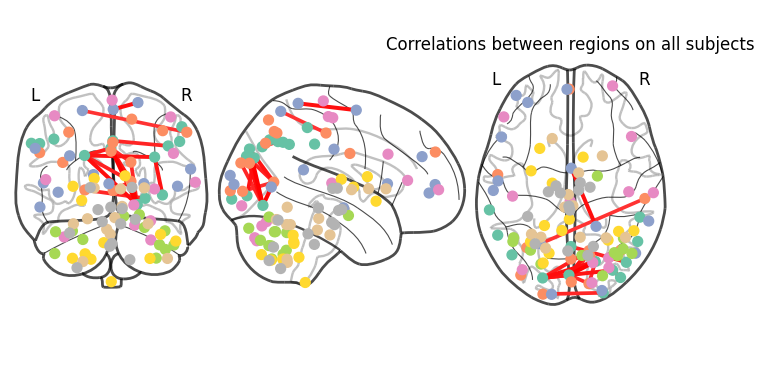

In [54]:
#plotting connections on the brain
plotting.plot_connectome(group_avg_correlation_matrix, atlas_coords, edge_threshold="99.7%")
plt.title("Correlations between regions on all subjects")

## Correlation Matrices Over 4 Time Windows

In [15]:
data = all_data
average_corr_matrices = []
time_per_group = data.shape[1] // 4

for group_idx in range(4):
    subject_corr_matrices = []
    
    start_time = group_idx * time_per_group
    end_time = start_time + time_per_group
    sub_matrix = data[:, start_time:end_time, :]
    for person_idx in range(data.shape[0]):
        subgroup_data = sub_matrix[person_idx, :, :]
        
        corr_matrix = np.corrcoef(subgroup_data.T)
        
        subject_corr_matrices.append(corr_matrix)
        break
    
    average_corr_matrix = np.mean(subject_corr_matrices, axis=0)
    
    average_corr_matrices.append(average_corr_matrix)
    

average_corr_matrices = np.array(average_corr_matrices)

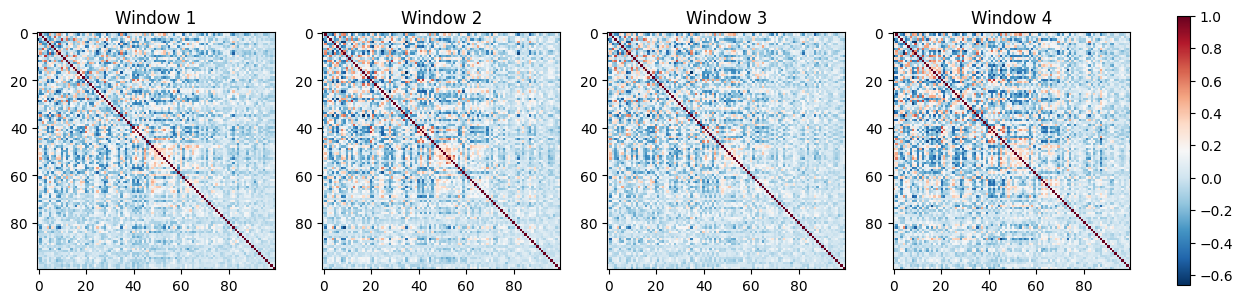

In [38]:
i =0
fig, axs = plt.subplots(1, 4, figsize=(15, 7))
for sub_corr_matrix in average_corr_matrices:
    img = axs[i].imshow(sub_corr_matrix, cmap="RdBu_r", interpolation="none")
    axs[i].set_title(f'Window {i+1}')
    i += 1
fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, shrink = 0.5)

## Investigate Overlapping Time Windows

In [39]:
path_file = 'HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2/100206.txt'
data = np.loadtxt(path_file, dtype=float)
data.shape

(4800, 100)

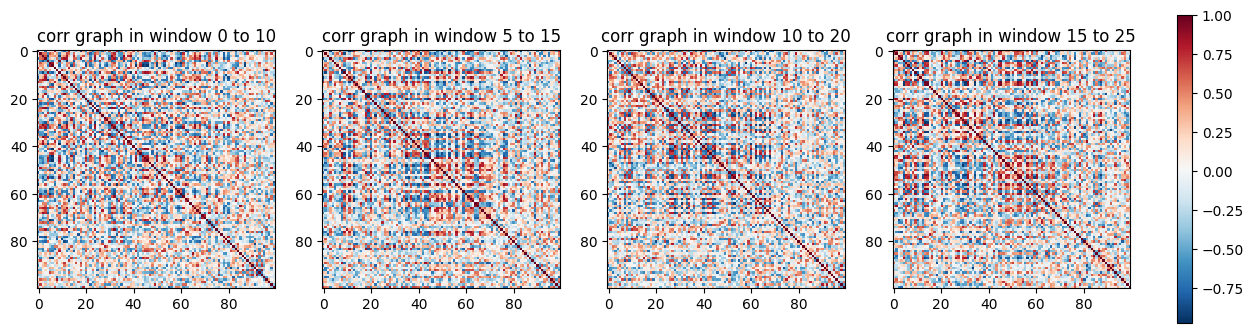

In [43]:
count = 0
j = 0
fig, axs = plt.subplots(1, 4, figsize=(15, 10))
for i in range(data.shape[0]):
    if count % 5 != 0:
        count += 1
        continue
    count += 1
    
    sub_data = data[i: i + 10]
    sub_corr_matrix = np.corrcoef(sub_data.T)
    img = axs[j].imshow(sub_corr_matrix, cmap="RdBu_r", interpolation="none")
    axs[j].set_title(f"corr graph in window {i} to {i+10}")
    j += 1
    if i + 5 == 20:
        break
fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, shrink = 0.4)